170498071/170498071 [==============================] - 13s 0us/step


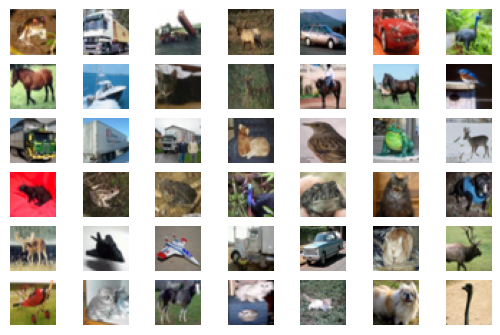

In [1]:
#load cifa10 dataset
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot

#load image
(trainX, trainY), (testX, testY) = load_data()

#plot training images
for i in range(42):
  #subplot define
  pyplot.subplot(7, 7, i+1)
  pyplot.axis('off')
  pyplot.imshow(trainX[i])
pyplot.show()

In [2]:
trainX.shape

(50000, 32, 32, 3)

In [3]:
#discriminator difining
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
#to visualize the architecture of the network
from keras.utils import plot_model
import numpy as np

In [4]:
#discriminator
#input_shape can be changed based one your image sizes
"""
max_pooling does downsampling, also stride does downsampling, but researches proven you can get better accuracy with stride.
"""
def difine_discriminator(in_shape=(32, 32, 3)):
  model = Sequential()

  model.add(Conv2D(64, kernel_size = (3,3), padding = 'same', input_shape=in_shape))
  model.add(LeakyReLU(alpha = 0.2))

  #downsampling
  model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', strides = (2,2)))
  model.add(LeakyReLU(alpha = 0.2))

  #downsampling
  model.add(Conv2D(128, kernel_size = (3,3), padding = 'same', strides = (2,2)))
  model.add(LeakyReLU(alpha = 0.2))

  #downsampling
  model.add(Conv2D(256, kernel_size = (3,3), padding = 'same', strides = (2,2)))
  model.add(LeakyReLU(alpha = 0.2))

  #classifier
  model.add(Flatten())
  model.add(Dropout(0.3))
  model.add(Dense(1, activation = 'sigmoid'))

  #compile
  adam = keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = .5)
  model.compile(loss = 'binary_crossentropy', optimizer = adam, metrics = ['accuracy'])

  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

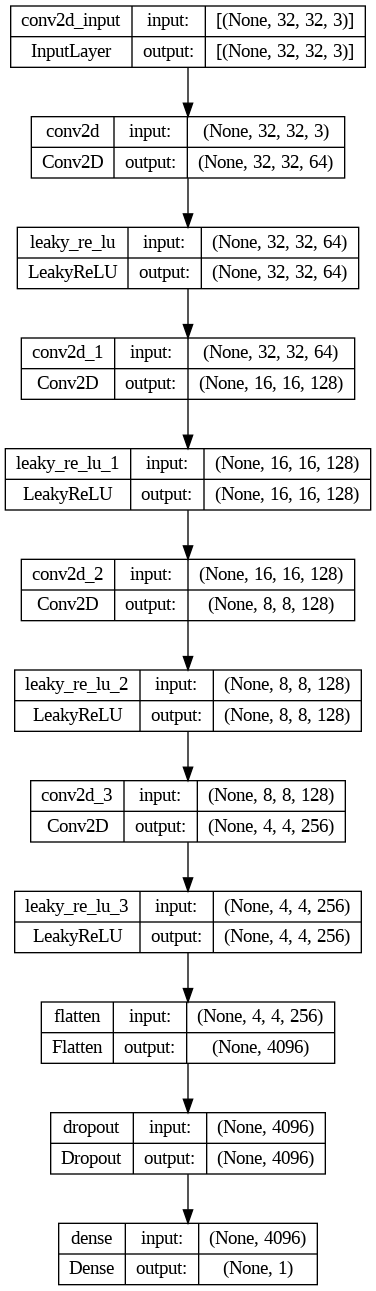

In [5]:
#difine the model
model = difine_discriminator()
model.summary()

#plot model
plot_model(model, to_file = 'Discriminator.png', show_shapes = True, show_layer_names = True)

In [6]:
"""
load and prepare cifar10 training images and scle it
"""
def load_real_sample():
  #load trainig data
  (trainX,_), (_, _) = load_data()

  #convert into float
  X = trainX.astype('float32')
  #scale to [-1, 1], from [0, 255]

  X = (X - 127.5) / 127.5

  return X

In [7]:
x = load_real_sample()
x.shape

(50000, 32, 32, 3)

In [8]:
x

array([[[[-0.5372549 , -0.5137255 , -0.5058824 ],
         [-0.6627451 , -0.6392157 , -0.64705884],
         [-0.60784316, -0.62352943, -0.6627451 ],
         ...,
         [ 0.23921569,  0.03529412, -0.15294118],
         [ 0.19215687, -0.01960784, -0.2       ],
         [ 0.16078432, -0.02745098, -0.19215687]],

        [[-0.8745098 , -0.84313726, -0.84313726],
         [-1.        , -1.        , -1.        ],
         [-0.85882354, -0.9372549 , -1.        ],
         ...,
         [-0.03529412, -0.30980393, -0.5686275 ],
         [-0.06666667, -0.34901962, -0.60784316],
         [-0.04313726, -0.31764707, -0.5529412 ]],

        [[-0.8039216 , -0.8117647 , -0.8352941 ],
         [-0.8745098 , -0.94509804, -1.        ],
         [-0.6156863 , -0.7882353 , -0.9372549 ],
         ...,
         [-0.07450981, -0.34117648, -0.60784316],
         [-0.05882353, -0.34117648, -0.60784316],
         [-0.14509805, -0.42745098, -0.67058825]],

        ...,

        [[ 0.6313726 ,  0.33333334, -0

In [9]:
#select batches from real data

def generate_real_samples(dataset, n_samples):
  #choose random instance
  index = np.random.randint(0, dataset.shape[0], n_samples)

  #selected images
  X = dataset[index]

  #generate real class lable as 1
  y = np.ones((n_samples, 1))

  return X, y

In [10]:
x, y = generate_real_samples(x, 64)
print(x.shape)
print(y.shape)

(64, 32, 32, 3)
(64, 1)


In [11]:
#generate fake/noise samples with lable

def generate_fake_samples(n_samples):
  #generate random numbers in [0, 1]
  X = np.random.rand(32 * 32 * 3 * n_samples)

  #update to range [-1, 1]
  X = -1 + X * 2

  #reshape into color image
  X = X.reshape((n_samples, 32,32,3))

  #generate fake class lable as 0
  y = np.zeros((n_samples, 1))

  return X, y

In [12]:
x, y = generate_fake_samples(64)
print(x.shape)
print(y.shape)

(64, 32, 32, 3)
(64, 1)


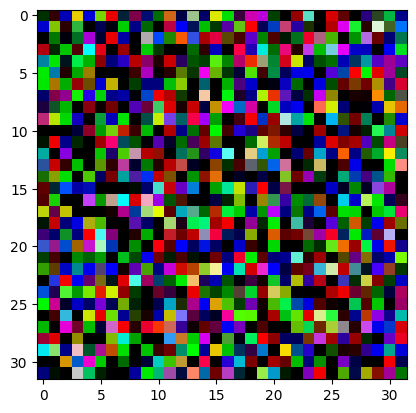

In [13]:
#see our fake/noise images
pyplot.imshow(x[0])

In [14]:
#temporary train discriminator model

def train_discriminator(model, dataset, n_iter=20, n_batch=128):
  half_batch = int(n_batch / 2)

  #manually enumarate epochs
  for i in range(n_iter):
    #get random real samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    #train discriminator on real data
    _, real_acc = model.train_on_batch(X_real, y_real)

    #generate noise/fake images
    X_fake, y_fake = generate_fake_samples(half_batch)
    #train discriminator on fake data
    _, fake_acc = model.train_on_batch(X_fake, y_fake)

    #performance
    print('>%d real = %.0f%% fake= %.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [15]:
#example model training

#discriminator dinifne
model = difine_discriminator()

#image data load
dataset = load_real_sample()

#fit model
train_discriminator(model, dataset)

>1 real = 38% fake= 0%
>2 real = 94% fake= 11%
>3 real = 94% fake= 36%
>4 real = 94% fake= 70%
>5 real = 97% fake= 97%
>6 real = 89% fake= 100%
>7 real = 94% fake= 100%
>8 real = 92% fake= 100%
>9 real = 94% fake= 100%
>10 real = 91% fake= 100%
>11 real = 98% fake= 100%
>12 real = 98% fake= 100%
>13 real = 97% fake= 100%
>14 real = 100% fake= 100%
>15 real = 100% fake= 100%
>16 real = 98% fake= 100%
>17 real = 98% fake= 100%
>18 real = 98% fake= 100%
>19 real = 98% fake= 100%
>20 real = 98% fake= 100%


In [16]:
#build Generator
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

In [17]:
from keras.src.backend import conv2d_transpose
#stand alone generator
def define_generator(latent_dim):
  model = Sequential()

  #4x4 image define
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes, input_dim = latent_dim))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Reshape((4, 4, 256)))

  #upsample to 8x8
  model.add(Conv2DTranspose(128, kernel_size = (4, 4), padding = 'same', strides = (2,2)))
  model.add(LeakyReLU(alpha = 0.2))

  #upsample to 16x16
  model.add(Conv2DTranspose(128, kernel_size = (4, 4), padding = 'same', strides = (2, 2)))
  model.add(LeakyReLU(alpha = 0.2))

  #upsample to 32x32
  model.add(Conv2DTranspose(128, kernel_size= (4, 4), padding = 'same', strides = (2, 2)))
  model.add(LeakyReLU(alpha = 0.2))

  #output layer
  model.add(Conv2D(3, (3, 3), activation = 'tanh', padding = 'same'))

  return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         524416    
 anspose)                                                        
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                           

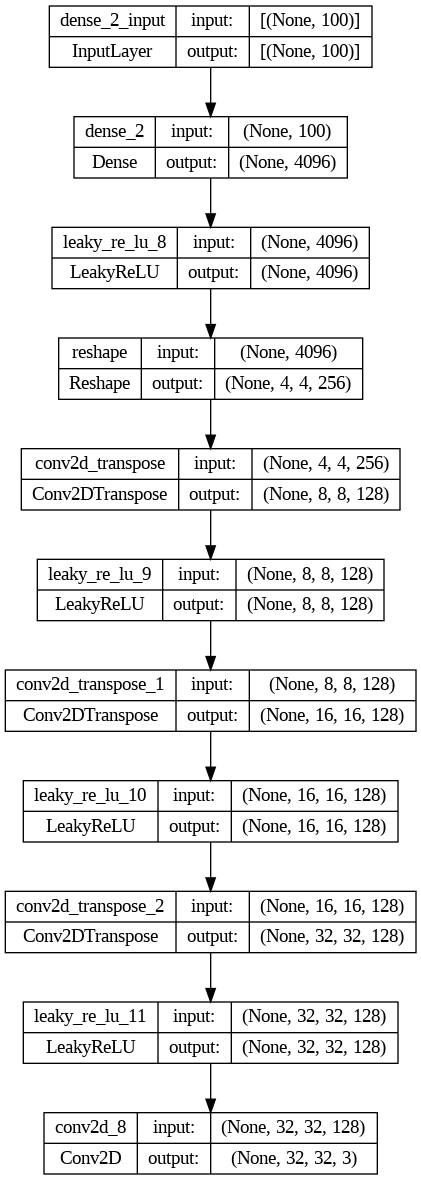

In [18]:
#define latent_dim
latent_dim = 100

#difine generator
model = define_generator(latent_dim)

#summary of model
model.summary()

#plot model
plot_model(model, to_file = 'generator_plot.png', show_shapes = True, show_layer_names = True)

In [19]:
#input for the generator
def generate_latent_points(latent_dim, n_samples):
  #generate latent
  x_input = np.random.randn(latent_dim * n_samples)

  #reshape for the network
  x_input = x_input.reshape(n_samples, latent_dim)

  return x_input


In [20]:
data = generate_latent_points(100,64)
print(data.shape)

(64, 100)


In [21]:
#use the generator to generate n fake examples with class labels
def generate_fake_images(g_model, latent_dim, n_sample):
  #generate latent space
  x_input = generate_latent_points(latent_dim, n_sample)

  #predict from generator
  X = g_model.predict(x_input)

  #create a fake class label 0
  y = np.zeros((n_sample,1))

  return X,y

2/2 [==============================] - 0s 115ms/step


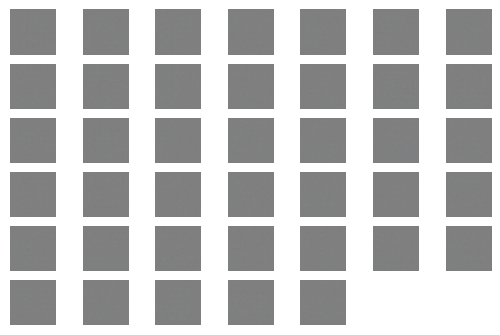

In [22]:
#size of the latent
latent_dim = 100

# define generator
model = define_generator(latent_dim)

#generate samples
n_sample = 40
X,_ = generate_fake_images(model, latent_dim, n_sample)

#scale from [-1,1] to [0,1]
X = (X + 1) / 2.0

#plot the generated samples
for i in range(n_sample):
  #define subplots
  pyplot.subplot(7,7,1+i)

  #turn of axis
  pyplot.axis('off')

  #plot raw pixel data
  pyplot.imshow(X[i])
pyplot.show()


In [23]:
#defining generator and discriminator model, for updating the generator
def define_gan(g_model,d_model):
  #make weights in the discriminator not trainable
  d_model.trainable = False

  #connect them
  model = Sequential()

  #add generator
  model.add(g_model)

  #add discriminator
  model.add(d_model)

  #compile model
  adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer = adam)

  return model


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1988612 (7.59 MB)
Trainable params: 1466115 (5.59 MB)
Non-trainable params: 522497 (1.99 MB)
_________________________________________________________________


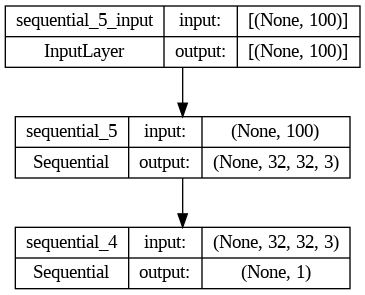

In [24]:
# size latent space
latent_dim = 100

#create discriminator
d_model = difine_discriminator()

#create generator
g_model = define_generator(latent_dim)

#create the GAN
gan_model = define_gan(g_model, d_model)

#summarize the gan
gan_model.summary()

#plot the gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
#train generator & dicriminator
def train(g_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128):
  bat_per_epo = int(dataset.shape[0]/n_batch)
  half_batch = int(n_batch/2)

  #manually enumerate epochs
  for i in range(n_epochs):
    #enumerate batches over the training set
    for j in range(bat_per_epo):
      #get randomly selected real samples
      X_real, y_real = generate_real_samples(dataset, half_batch)

      #update discriminator model weights
      d_loss1,_ = d_model.train_on_batch(X_real, y_real)

      #generate fake examples
      X_fake, y_fake = generate_fake_images(g_model,latent_dim, half_batch)

      #update discriminator model weights
      d_loss2,_ = d_model.train_on_batch(X_fake, y_fake)

      #prepare points in the latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)

      # create inverted labels for fake samples
      y_gan = np.ones((n_batch,1))

      #update the generator via the discriminator'r error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      #summarize loss on this batches
      print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
            (i+i, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

    #evaluate the model performance sometimes
    if (i+1) % 10 ==0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [26]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epochs, g_model, d_model, dataset, latent_dim, n_sample=150):
  #prepare real sample
  X_real, y_real = generate_real_samples(dataset, n_sample)

  #evaluate dicriminator on real examples
  _,acc_real = d_model.evaluate(X_real, y_real, verbose=0)

  #prepare fake examples
  X_fake, y_fake = generate_fake_images(g_model,latent_dim, n_sample)

  #evaluate dicriminator on fake examples
  _,acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)

  # summarize discriminator performance
  print(">Accuracy real: %.0f%%, fake: %.0f%%" % (acc_real*100, acc_fake*100))

  #save plot
  save_plot(X_fake, epochs)

  # save the generator model title file
  filename = 'generator_model_%03d.h5' % (epochs+1)
  g_model.save(filename)

In [27]:
# create and save a plot of generated images
def save_plot(examples, epochs,n=7):
  #scale the pixel value from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0

  #plot the generated samples
  for i in range(n*n):
    #define subplots
    pyplot.subplot(n,n,1+i)
    #turn of axis
    pyplot.axis('off')
    #plot raw pixel data
    pyplot.imshow(examples[i])

  #save plot as file
  filename = 'generated_plot_%03d.png' % (epochs+1)
  pyplot.savefig(filename)
  pyplot.close()


In [28]:
train(g_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=128)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
>6, 232/390, d1=0.698, d2=0.459, g=1.109
2/2 [==============================] - 0s 12ms/step
>6, 233/390, d1=0.637, d2=0.543, g=1.095
2/2 [==============================] - 0s 5ms/step
>6, 234/390, d1=0.651, d2=0.562, g=1.139
2/2 [==============================] - 0s 12ms/step
>6, 235/390, d1=0.625, d2=0.514, g=1.131
2/2 [==============================] - 0s 11ms/step
>6, 236/390, d1=0.650, d2=0.540, g=1.085
2/2 [==============================] - 0s 4ms/step
>6, 237/390, d1=0.538, d2=0.574, g=1.084
2/2 [==============================] - 0s 4ms/step
>6, 238/390, d1=0.519, d2=0.607, g=1.074
2/2 [==============================] - 0s 4ms/step
>6, 239/390, d1=0.572, d2=0.533, g=1.009
2/2 [==============================] - 0s 6ms/step
>6, 240/390, d1=0.517, d2=0.579, g=1.042
2/2 [==============================] - 0s 9ms/step
>6, 241/390, d1=0.585, d2=0.629, g=0.990
2/2 [=====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 5ms/step
>26, 232/390, d1=0.748, d2=0.573, g=0.960
2/2 [==============================] - 0s 5ms/step
>26, 233/390, d1=0.766, d2=0.589, g=0.957
2/2 [==============================] - 0s 8ms/step
>26, 234/390, d1=0.672, d2=0.564, g=0.934
2/2 [==============================] - 0s 16ms/step
>26, 235/390, d1=0.704, d2=0.634, g=0.866
2/2 [==============================] - 0s 4ms/step
>26, 236/390, d1=0.625, d2=0.609, g=0.907
2/2 [==============================] - 0s 7ms/step
>26, 237/390, d1=0.590, d2=0.742, g=0.966
2/2 [==============================] - 0s 5ms/step
>26, 238/390, d1=0.671, d2=0.576, g=0.976
2/2 [==============================] - 0s 11ms/step
>26, 239/390, d1=0.654, d2=0.553, g=0.924
2/2 [==============================] - 0s 3ms/step
>26, 240/390, d1=0.628, d2=0.601, g=0.883
2/2 [==============================] - 0s 12ms/step
>26, 241/390, d1=0.629, d2=0.625, g=0.857
2/2 [===========

*************************************
after training

4/4 [==============================] - 0s 43ms/step


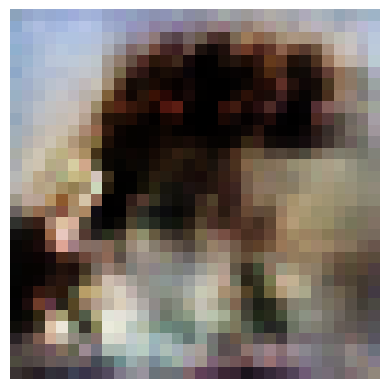

100

In [29]:
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot


def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input


def create_plot(examples, n):
  for i in range(n * n):
    pyplot.subplot(n,n,1+i)
    pyplot.axis("off")
    pyplot.imshow(examples[i, :, :])
  pyplot.show()


#load model
model = load_model("/content/generator_model_010.h5")
latent_point = generate_latent_points(100,100)
X = model.predict(latent_point)

X = (X+1)/2.0
create_plot(X,1)

X.shape[0]